In [1]:
from ioMicro import *
from ioMicroPostFits import *

\\192.168.0.79\Public\Adam\E200_WTC11_WTday3__8_31_2023\AnalysisDeconvolve_CG\combinatorial

In [3]:
analysis_folder = r'\\192.168.0.79\Public\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG'
cp=chromatin_postfits(save_folder =analysis_folder,
                 tag = '*--H*_R*--col*__Xhfits.npz',exclude_tag = None,tag_save='',remap=False,nHs=63)

[63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]
Detected fovs: 211 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 3

In [11]:
segmentation_folder = r'\\192.168.0.79\Public\Adam\E200_WTC11_WTday3__8_31_2023\AnalysisDeconvolve_CG\combinatorial'
def get_R(fl,letTag='R'): 
        try:
            icol = get_icol(fl)
            return np.array(get_Htag(fl).replace(letTag,'').split('_')[1:],dtype=int)[icol]
        except:
            return -1
def reorder_on_R(fls):
    return np.array(fls)[np.argsort([get_R(fl) for fl in fls])]

def load_segmentation(dec,folder =  segmentation_folder):
    dec.fl_dapi = glob.glob(folder+os.sep+dec.fov+'*'+dec.set_+'*.npz')[0]
    dic = np.load(dec.fl_dapi)
    im_segm = dic['segm']
    dec.shape = dic['shape']
    dec.im_segm_=im_segm
    dec.segm_tag = os.path.basename(dec.fl_dapi).split('--')[1]
def main_func(ifov,redo_fov=False,redo_drift=False,nbest=80,nexpand=5):
    
    
    cp.ifov = ifov
    ### map the files  ##################################
    cp.set_ = ''
    fls = cp.dic_fls[cp.ifov]
    fls = reorder_on_R(fls)
    cp.fov = get_fullfov(fls[0])
    save_fld_cell = cp.save_folder+os.sep+'best_per_cell'
    if not os.path.exists(save_fld_cell): os.makedirs(save_fld_cell)
    save_fld_cell_ = save_fld_cell#+'V2'
    if not os.path.exists(save_fld_cell_): os.makedirs(save_fld_cell_)
    cp.save_fl = save_fld_cell_+os.sep+cp.fov+'--'+cp.set_+'__XHfs_finedrft.npz'
    
    if not os.path.exists(cp.save_fl) or redo_fov:
        print("Computing/Loading drift...")
        ### Compute the drift for all hybes #########################
        to_dapi_dic = {fitfl:fit_fl_TO_dapiFeat_fl(fitfl) for fitfl in fls}
        dapi_fls = np.unique(list(to_dapi_dic.values()))
        dapi_fls = list(dapi_fls)

        ########## Add dapi drift features for the segmentation file
        fov__ = cp.fov.replace('.zarr','')
        extra_fl = os.path.dirname(segmentation_folder)+os.sep+fov__+'--H1_DMER_1--dapiFeatures.npz'
        dapi_fls+=[extra_fl]
        
        drift_fl  = save_fld_cell+os.sep+'driftNew_'+cp.fov+'--'+cp.set_+'.pkl'
        if not os.path.exists(drift_fl) or redo_drift:
            fl_ref = dapi_fls[len(dapi_fls)//2]

            dic_drift = {}
            for fl in tqdm(dapi_fls):
                dic_drift[fl] = get_best_translation_pointsV2(fl,fl_ref,resc=5)
                #print(fl,dic_drift[fl])

            pickle.dump([list(dic_drift.values()),list(dic_drift.keys()),cp.fov,fl_ref],open(drift_fl,'wb'))
        else:
            drifts,fls_,fov_,fl_ref = np.load(drift_fl,allow_pickle=True)
            dic_drift = dict(zip(fls_,drifts))
        print("Maximum drift:",np.max([np.abs(dic_drift[key][0]) for key in dic_drift],axis=0))
    
        ### load all the fitted data ##################################
        XH = None
        print("Load the fitted data and apply drift correction to dots...")
        for fl in tqdm(fls):
            #Xhs,dic_drift = pickle.load(open(fl,'rb'))
            Xh = np.load(fl,allow_pickle=True)['Xh']
            if len(Xh.shape)>0:
                Xh = Xh[Xh[:,-2]>0.25] ### filter by correlation with PSF
                drift = dic_drift[to_dapi_dic[fl]][0]
                Xh[:,:3] = Xh[:,:3]+drift ################what sign - this is a plus on Kiwi
                iR = get_R(fl)-1
                icol = get_icol(fl)
                Xh_ = np.concatenate([Xh,np.array([[icol,iR]]*len(Xh))],axis=-1)
                if XH is None:
                    XH = Xh_
                else:
                    XH = np.concatenate([XH,Xh_],axis=0)
        if False:
            ### Visualize to see if the drift correction failed
            resc = [1,1,1]
            XH_ = XH.copy()
            iHs = (XH_[:,-1]).astype(int)
            XH_kp = XH_[iHs==0]
            h = XH_kp[:,-3]
            size = np.clip(h/15000,0,1)*0.2
            x,y = (XH_kp[:,1:3]*resc[1:3]).T
            plt.scatter(x,y,s=size/50,c='r')
            XH_kp = XH_[iHs==80]
            h = XH_kp[:,-3]
            size = np.clip(h/15000,0,1)*0.2
            x,y = (XH_kp[:,1:3]*resc[1:3]).T
            plt.scatter(x,y,s=size/50,c='g')
        print("Loading segmentation...")
        load_segmentation(cp)
        cp.im_segm_ = expand_segmentation(cp.im_segm_, nexpand=nexpand)
        ### Compute drift between the segmentation file and the reference drift file
        print("Compute drift correction segmentation file...")
        tzxy_seg = np.round([dic_drift[key][0] for key in dic_drift if cp.segm_tag in key]).astype(int)
        #tzxy_seg
        
        ### Augment the fitting data with cell id
        resc = cp.im_segm_.shape/cp.shape
        XH_ = XH.copy()
        XH_[:,:3] = XH_[:,:3]-tzxy_seg ### bring fits to cell segmentation space - modified to -
        XC = (XH_[:,:3]*resc).astype(int) #rescale to segmentation size
        keep = np.all(XC>=0,axis=-1)&np.all(XC<cp.im_segm_.shape,axis=-1)
        icells = np.zeros(len(XC))
        icells[keep]=cp.im_segm_[tuple(XC[keep].T)]
        XH_f = np.concatenate([XH_,icells[:,np.newaxis]],axis=-1)
        cp.XH_f=XH_f
        
        ### Keep best fits per cell and exclude background
        print("Keeping best points per cell:"+str(nbest))
        XH_fs = keep_best_per_cell_fast(XH_f,nbest=nbest)
        cp.XH_fs=XH_fs
        np.savez(cp.save_fl,XH_fs=XH_fs)
        print("Saved the augmented fits to file:",cp.save_fl)

In [ ]:
### Test for one FOV (i.e. FOV5)

In [12]:
main_func(5)

Computing/Loading drift...


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:44<00:00,  2.03s/it]


Maximum drift: [ 0.99442524 27.347977   13.224944  ]
Load the fitted data and apply drift correction to dots...


100%|██████████████████████████████████████████████████████████████████████████████████| 63/63 [00:12<00:00,  5.06it/s]


Loading segmentation...
Compute drift correction segmentation file...
Keeping best points per cell:80
Saved the augmented fits to file: \\192.168.0.79\Public\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG\best_per_cell\Conv_zscan__005--__XHfs_finedrft.npz


In [15]:
###load data
print(cp.save_fl)
XH_f = np.load(cp.save_fl)['XH_fs']
XHB = keep_best_per_cell_fast(XH_f,1)

\\192.168.0.79\Public\Adam\One_by_one\E200_WTC11_WTday3__8_31_2023\AnalysisDevonvCG\best_per_cell\Conv_zscan__005--__XHfs_finedrft.npz


In [16]:
import napari
X = XHB[:,:3]
H = XHB[:,-4]
vmax = np.median(H)#,95)
size = np.clip(H/vmax,0,1)*1
V = napari.view_points(X,size=size,blending='Additive',edge_width=0)

### Run EM and check distance matrix

100%|███████████████████████████████████████████████████████████████████████████████| 696/696 [00:04<00:00, 158.73it/s]


Detected number of chromosomes:956
Number of cells with 1 chromosomes: 298
Number of cells with 2 chromosomes: 299
Number of cells with 3 chromosomes: 20


100%|██████████████████████████████████████████████████████████████████████████████| 956/956 [00:00<00:00, 1513.85it/s]
C:\Scripts\WTC11\ioMicroPostFits.py:104: RuntimeWarning: invalid value encountered in divide
  ret_ = ret[n_ - 1:] / ret_nan[n_ - 1:]


EM iteration number:  1


100%|███████████████████████████████████████████████████████████████████████████████| 956/956 [00:03<00:00, 292.51it/s]


fraction the same: 0.8651324965132496
fraction nan: 0.2678347280334728
EM iteration number:  2


100%|███████████████████████████████████████████████████████████████████████████████| 956/956 [00:03<00:00, 295.94it/s]


fraction the same: 0.9815202231520224
fraction nan: 0.2678347280334728
EM iteration number:  3


100%|███████████████████████████████████████████████████████████████████████████████| 956/956 [00:03<00:00, 296.45it/s]


fraction the same: 0.9958856345885635
fraction nan: 0.2678347280334728
EM iteration number:  4


100%|███████████████████████████████████████████████████████████████████████████████| 956/956 [00:03<00:00, 283.43it/s]


fraction the same: 0.9988319386331939
fraction nan: 0.2678347280334728


C:\Scripts\WTC11\ioMicroPostFits.py:826: RuntimeWarning: Mean of empty slice
  cm = np.nanmean(Xf[:,:,:],axis=1)[:,np.newaxis]
C:\Users\ClevelandLab\anaconda3\envs\napari\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
C:\Users\ClevelandLab\anaconda3\envs\napari\lib\site-packages\numpy\lib\nanfunctions.py:1095: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)


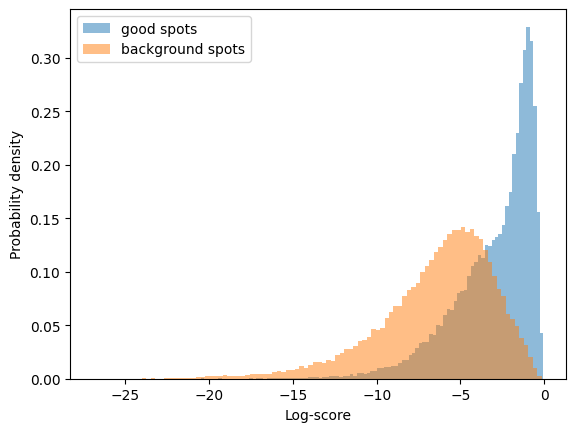

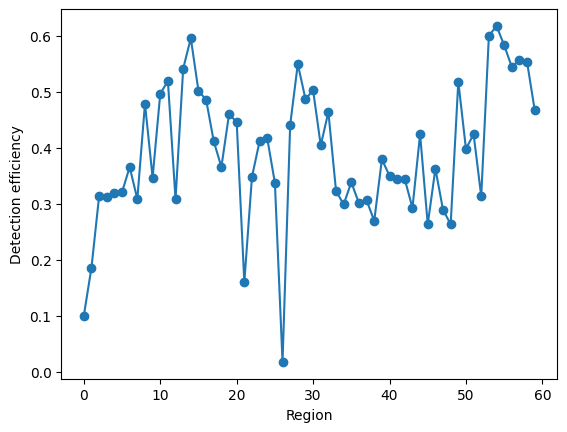

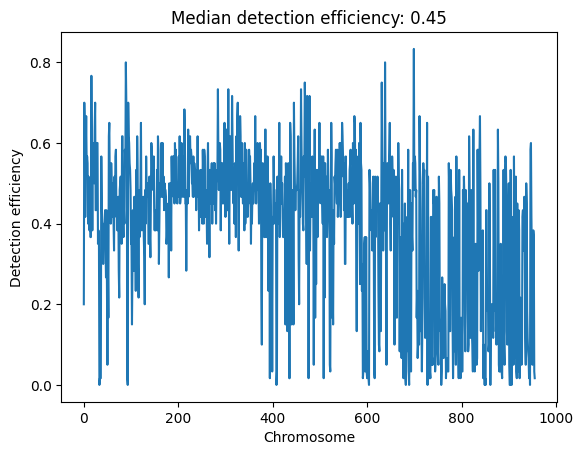

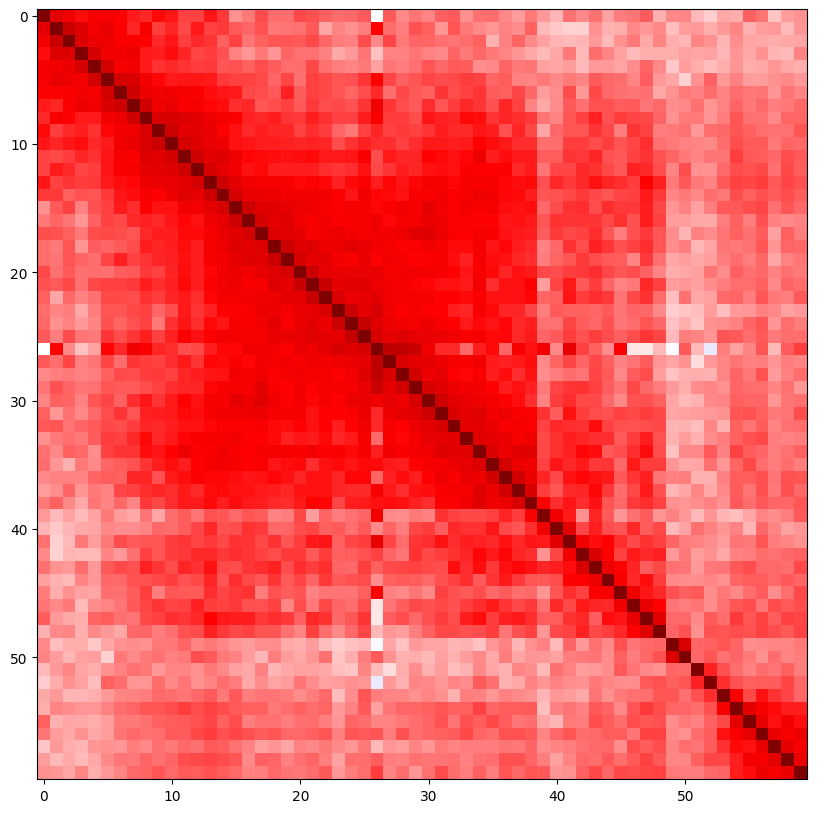

NameError: name 'save_fl' is not defined

In [23]:
XH_fs = np.load(cp.save_fl)['XH_fs']
Rs = XH_fs[:,-2]
XH_fs=XH_fs[Rs>=0]
get_X_cands(cp,keep_best_per_cell_fast(XH_fs,20),nchr_=3,pix=[0.300,0.1083,0.1083],
                     radius_chr = 2.,radius_cand =2,fr_th=0.35,nelems=2,plt_val = False)
Rs = np.unique(XH_fs[:,-2])
uRs = np.arange(np.max(Rs)+1).astype(int)#np.unique(Rs).astype(int)
initialize_with_max_brightness(cp,nkeep = 8000,Rs_u = uRs)
normalize_color_brightnesses(cp)
run_EM(cp,nkeep = 80000,niter = 4,Rs_u = uRs)
get_scores_and_threshold(cp,th_score = -2.5)
plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1.5)#,vmin=0,vmax=0.5)
plt.show()

cells = cp.icell_cands
ifov = get_fov(save_fl)
cells_f = np.array(cells)+ifov*10**5

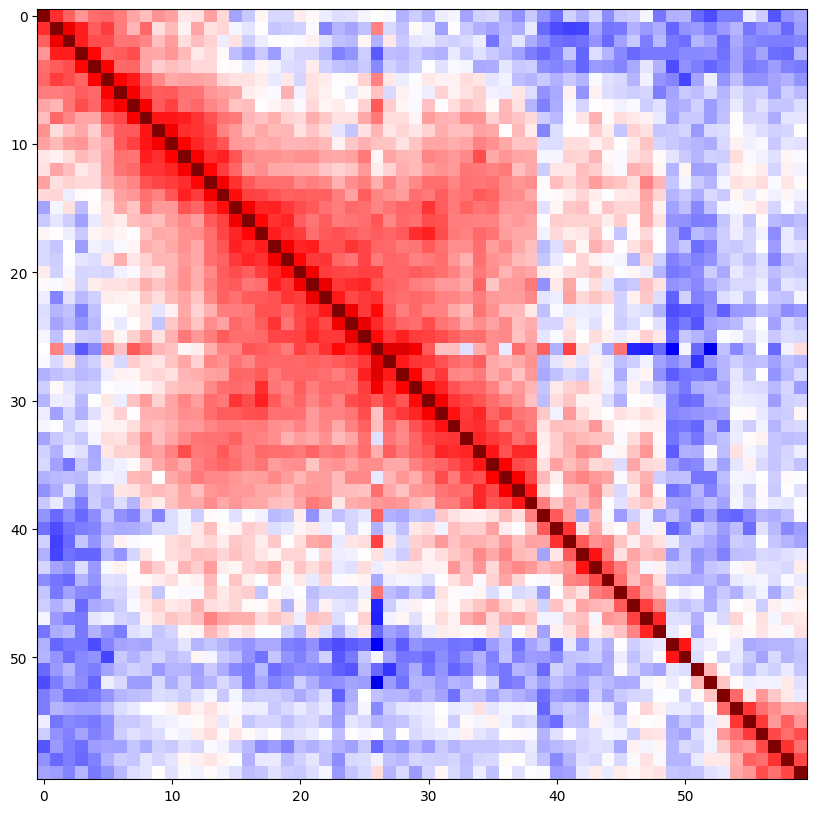

In [24]:
plot_matrix(cp,th_score=-2.5,lazy_color_correction = True,vmin=0,vmax=1)

In [ ]:
https://drive.google.com/drive/folders/1pO1L866cbOMdF5gLrWS7WA8D8XiowJkE

### Run across all fovs

In [ ]:
ifovs_all = list(cp.completed_fovs)
for ifov in tqdm(ifovs_all):
    try:
        main_func(ifov)
    except:
        print("Failed",ifov)

  0%|                                                                                          | 0/211 [00:00<?, ?it/s]

Computing/Loading drift...



 32%|██████████████████████████▍                                                        | 7/22 [00:12<00:24,  1.64s/it]

In [10]:
1250*4/(51*3)

32.6797385620915